In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [3]:
with open('train.json', 'r') as file:
    data = json.load(file)
df = pd.DataFrame(data)

print(df.head())
print(df.info())
print(df.describe())
print(df['is_iceberg'].value_counts())

         id                                             band_1  \
0  dfd5f913  [-27.878361, -27.15416, -28.668615, -29.537971...   
1  e25388fd  [-12.242375, -14.920305, -14.920363, -12.66633...   
2  58b2aaa0  [-24.603676, -24.603714, -24.871029, -23.15277...   
3  4cfc3a18  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  271f93f4  [-26.006956, -23.164886, -23.164886, -26.89116...   

                                              band_2 inc_angle  is_iceberg  
0  [-27.154118, -29.537888, -31.0306, -32.190483,...   43.9239           0  
1  [-31.506321, -27.984554, -26.645678, -23.76760...   38.1562           0  
2  [-24.870956, -24.092632, -20.653963, -19.41104...   45.2859           1  
3  [-27.889421, -27.519794, -27.165262, -29.10350...   43.8306           0  
4  [-27.206915, -30.259186, -30.259186, -23.16495...   35.6256           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dt

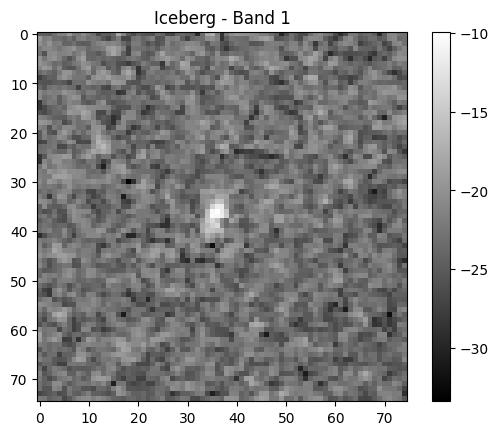

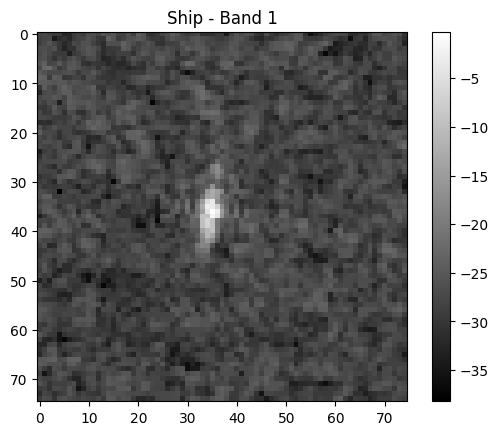

In [4]:


def plot_image(image_data, title):
    image = np.array(image_data).reshape(75, 75)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

example_iceberg = df[df['is_iceberg'] == 1].iloc[0]
example_ship = df[df['is_iceberg'] == 0].iloc[0]
plot_image(example_iceberg['band_1'], 'Iceberg - Band 1')
plot_image(example_ship['band_1'], 'Ship - Band 1')

In [5]:
X = np.array([np.array(band).reshape(75, 75) for band in df['band_1']])
X = np.stack((X, np.array([np.array(band).reshape(75, 75) for band in df['band_2']])), axis=-1)


y = df['is_iceberg'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
#random forest

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train)

y_pred = rf.predict(X_val_flat)
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.72      0.73       157
           1       0.74      0.75      0.74       164

    accuracy                           0.74       321
   macro avg       0.74      0.73      0.73       321
weighted avg       0.74      0.74      0.74       321



In [7]:

df['inc_angle'] = pd.to_numeric(df['inc_angle'], errors='coerce')
df['inc_angle'].fillna(df['inc_angle'].mean(), inplace=True)

def preprocess_images(df):
    band_1 = np.array([np.array(band).reshape(75, 75) for band in df['band_1']])
    band_2 = np.array([np.array(band).reshape(75, 75) for band in df['band_2']])
    return np.stack((band_1, band_2), axis=-1)

X = preprocess_images(df)
y = df['is_iceberg'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train / np.max(X_train)
X_val = X_val / np.max(X_val)

C:\Users\Marko\AppData\Local\Temp\ipykernel_8624\2762176199.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['inc_angle'].fillna(df['inc_angle'].mean(), inplace=True)


In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(75, 75, 2)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\Marko\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 32)     │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,033 (3.42 MB)

 Trainable params: 896,033 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.5142 - loss: 0.6786 - val_accuracy: 0.6698 - val_loss: 0.5884
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.6291 - loss: 0.5651 - val_accuracy: 0.6854 - val_loss: 0.5726
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.6830 - loss: 0.5425 - val_accuracy: 0.7321 - val_loss: 0.5208
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.7387 - loss: 0.4940 - val_accuracy: 0.7072 - val_loss: 0.5525
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7315 - loss: 0.4935 - val_accuracy: 0.8224 - val_loss: 0.4059
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.8284 - loss: 0.3872 - val_accuracy: 0.8255 - val_loss: 0.4134
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8164 - loss: 0.3969 - val_accuracy: 0.8629 - val_loss: 0.3339
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.8569 - loss: 0.3276 - val_accuracy: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8933 - loss: 0.2619
Validation Loss: 0.2695927023887634
Validation Accuracy: 0.8909657597541809


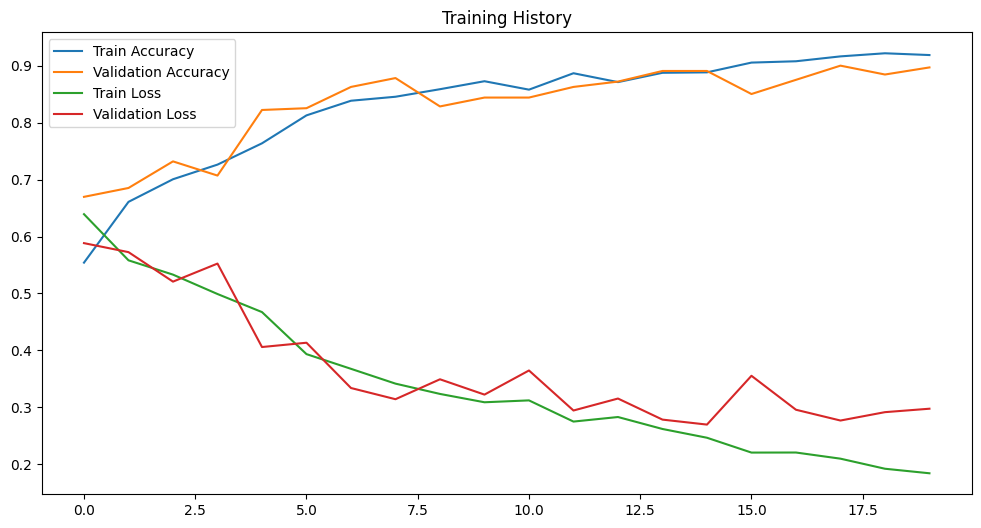

In [8]:

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training History')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


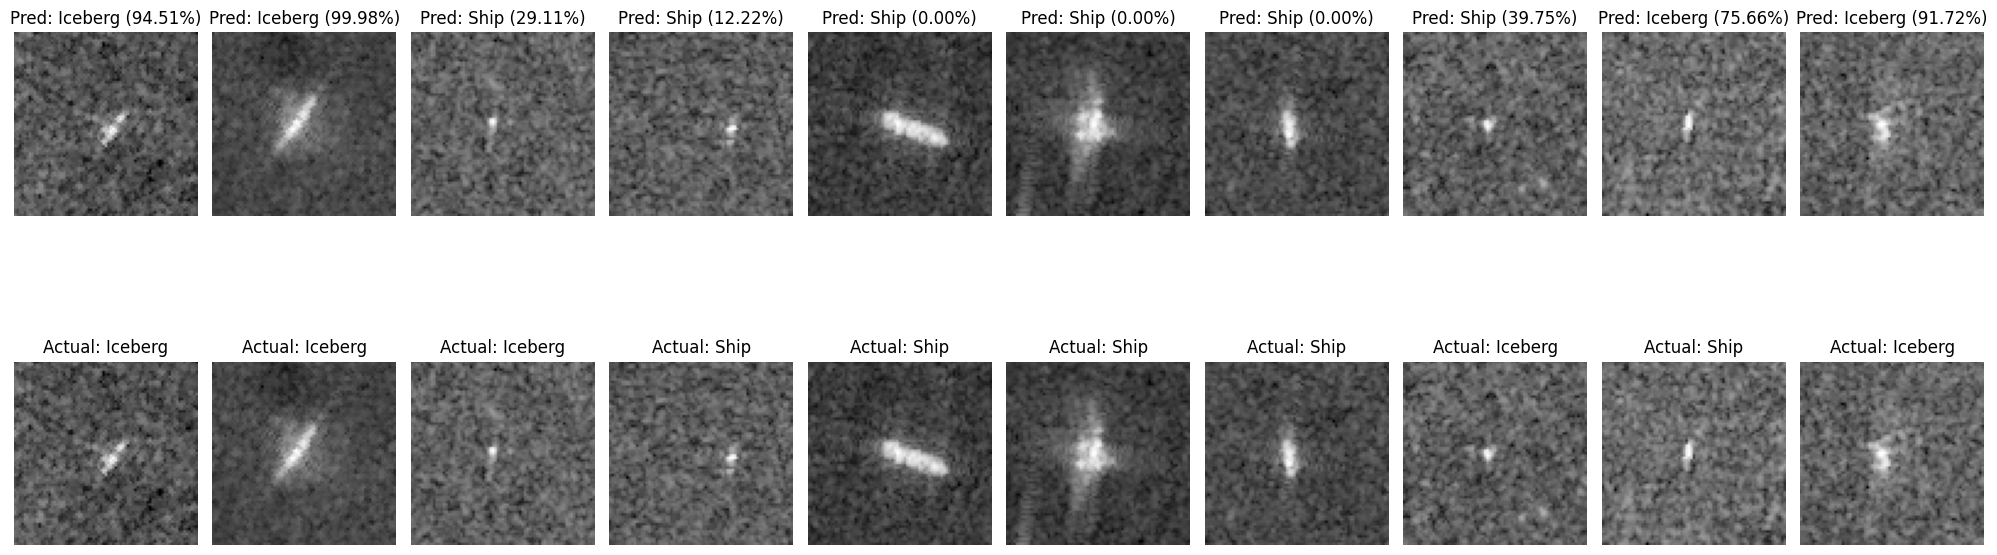

In [11]:
num_images = 10
indices = np.random.choice(len(X_val), num_images, replace=False)
selected_images = X_val[indices]
selected_labels = y_val[indices]

predictions = model.predict(selected_images)
predicted_labels = (predictions > 0.5).astype(int).flatten()

fig, axes = plt.subplots(2, num_images, figsize=(20, 8))

for i, (image, pred, actual) in enumerate(zip(selected_images, predicted_labels, selected_labels)):
    prediction_prob = predictions[i][0] * 100
    
    ax = axes[0, i]
    ax.imshow(image[:, :, 0], cmap='gray')
    ax.set_title(f"Pred: {'Iceberg' if pred == 1 else 'Ship'} ({prediction_prob:.2f}%)")
    ax.axis('off')
    
    ax = axes[1, i]
    ax.imshow(image[:, :, 0], cmap='gray')
    ax.set_title(f"Actual: {'Iceberg' if actual == 1 else 'Ship'}")
    ax.axis('off')

plt.tight_layout()
plt.show()
